In [3]:
#!pip install py3dep
#import py3dep
#!pip install pysheds
#!pip install osgeo

import geopandas as gpd
import pandas as pd
import matplotlib as plot
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point
import numpy as np
from osgeo import gdal, os, ogr, osr
from shapely.geometry import Polygon
import matplotlib.colors as colors
import pysheds
from pysheds.grid import Grid

#from pysheds import Grid
import fiona
from fiona.crs import from_epsg
from fiona.crs import from_string



In [29]:
#reading in data with relative paths so that it can be used by others who clone repository from github
script_dir = os.getcwd()
script_dir
# need to use '..' to go up to parent directory to access observations
accretion_path = os.path.join(script_dir, '..', 'shp','wfk_catchments2')
accretion_path = os.path.abspath(accretion_path)  # Resolve '..' and convert to an absolute path
accretion_path


'd:\\Ben_wd\\THESIS\\heatsource\\post_defense\\accretion_model\\shp\\wfk_catchments2'

### Delineating catchments for each flowtracker measurement


In [30]:
def batch_catchment_delineation(burneddem, pointslist):
    pointslist = pd.read_csv(pointslist)
    for index, row in pointslist.iterrows():
         # make a grid the size of dem
        grid = Grid.from_raster(burneddem, data_name='dem')
        # give grid dem data
        dem = grid.read_raster(r'D:\Ben_wd\THESIS\watershed\tif\WFK_demsubset4326_fillburn.tif')
        # hydrocondition dem
        pit_filled_dem = grid.fill_pits(dem)
        flooded_dem = grid.fill_depressions(pit_filled_dem)
        inflated_dem = grid.resolve_flats(flooded_dem)
        # # Compute flow direction
        dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
        fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
        # Calculate flow accumulation
        acc = grid.accumulation(fdir, dirmap=dirmap)
        # Delineate a catchment
        #pointslist = pd.read_csv(pointslist)
        # read point xy
        x, y =     row['Lon'], row['Lat']
        name = str(row['Name'])
        # Snap pour point 
        x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

        # Delineate the catchment
        catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                               xytype='coordinate')

        # Crop and export catchment as shapefile the catchment
        grid.clip_to(catch)
        catch_view = grid.view(catch, dtype=np.uint8)
        shapes = grid.polygonize(catch_view)

        # Specify schema
        schema = {'geometry': 'Polygon',
                'properties': {'LABEL': 'float:16'}}
        # Write shapefile
        # Define the Proj4 string for EPSG 4326 (WGS 84)
        crs_proj4 = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

        # Create a CRS object from the Proj4 string
        crs = from_string(crs_proj4)


        #with fiona.open(r'D:\Ben_wd\THESIS\watershed\shp\wshdoutput\wgs84\autocatchment4326_'+ str(name) + '.shp', 'w',
        with fiona.open(os.path.join(accretion_path, 'autocatchment4326_'+ str(name)) + '.shp', 'w',
              
                        driver='ESRI Shapefile',
                        crs=crs,
                        schema=schema) as c:
            i = 0
            for shape, value in shapes:
                rec = {}
                rec['geometry'] = shape
                rec['properties'] = {'LABEL' : str(value)}
                rec['id'] = str(i)
                c.write(rec)
                i += 1








In [32]:
batch_catchment_delineation(burneddem = r'D:\Ben_wd\THESIS\watershed\tif\WFK_demsubset4326_fillburn.tif',
                                     pointslist = r'D:\Ben_wd\THESIS\flowtracker\FlowtrackerXYDischarge_nooutliers.csv')



In [28]:
test = pd.read_csv(r'D:\Ben_wd\THESIS\flowtracker\FlowtrackerXYDischarge_nooutliers.csv')
test

,Name,Lat,Lon,Discharge
0,Sb_conf,43.595100,-90.782040,0.2740
1,Sb_crumedown,43.604770,-90.834870,0.0980
2,Sb_crumetrib,43.603910,-90.837360,0.0730
3,Sb_crumeup,43.603050,-90.839470,0.0520
4,Sb_thdown,43.606780,-90.808920,0.2260
5,SB_thup,43.610060,-90.813530,0.2100
6,Wfsc_down2,43.596940,-90.780300,0.6940
7,Wfsc_up,43.599750,-90.779830,0.6200
8,Wf_bloomtrib,43.643990,-90.783590,0.0010
9,Wf_boydtrib,43.653970,-90.778880,0.0420


### Finding the amount of landform classes in each catchment

In [17]:
import os
import geopandas as gpd
import pandas as pd
from pyproj import CRS
from shapely.geometry import box

# Specify the folder containing the larger shapefiles
larger_shapefile_path = r'D:\Ben_wd\THESIS\watershed\shp\WFK_SSURGO\WFK_landformsFINAL6608.shp'

# Specify the folder containing the smaller shapefile for clipping
smaller_shapefiles_folder = accretion_path

# Specify the target CRS (EPSG 6608)
target_crs = CRS.from_epsg(6608)

# Read the larger shapefile
larger_gdf = gpd.read_file(larger_shapefile_path)

# Reproject the larger shapefile to the target CRS
larger_gdf = larger_gdf.to_crs(target_crs)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['SmallerShapefile'])
# Loop through smaller shapefiles in the folder
for filename in os.listdir(smaller_shapefiles_folder):
    if filename.endswith(".shp"):
        # Construct the full path to the smaller shapefile
        smaller_shapefile_path = os.path.join(smaller_shapefiles_folder, filename)

        # Read the smaller shapefile
        smaller_gdf = gpd.read_file(smaller_shapefile_path)

        # Reproject the smaller shapefile to the target CRS
        smaller_gdf = smaller_gdf.to_crs(target_crs)

        # Clip the larger shapefile with the smaller shapefile
        clipped_gdf = gpd.overlay(larger_gdf, smaller_gdf, how='intersection')

        # Get a list of unique classes from the clipped result
        unique_classes = clipped_gdf['landform_2'].unique()

        # Create a dictionary to store class areas
        class_areas = {}

        # Calculate areas for each class within the clipped areas
        for class_name in unique_classes:
            class_gdf = clipped_gdf[clipped_gdf['landform_2'] == class_name]
            class_area = class_gdf.geometry.area.sum()/1000000
            class_areas[class_name] = class_area

            # Add results to the DataFrame
            results_df = results_df.append({'SmallerShapefile': filename, **class_areas}, ignore_index=True)

# Fill any NaN values in the DataFrame with 0
results_df = results_df.fillna(0)
selected_rows = results_df.iloc[2::3]
selected_rows['TotalArea'] = results_df.sum(axis=1)
#selected_rows.rename(columns={'SmallerShapefile': 'Site', '1' : 'Valley', '2': 'Hillside', '3': 'Ridgetop'}, inplace=True)

# Save the results DataFrame to a CSV file
selected_rows.to_csv(os.path.join(accretion_path, 'csv'), index = False)#r'D:\Ben_wd\THESIS\watershed\csv\class_areas2.csv', index=False)

print('Class areas within the clipped areas have been calculated and saved to class_areas.csv')


AttributeError: 'DataFrame' object has no attribute 'append'

In [35]:
import os
import geopandas as gpd
import pandas as pd
from pyproj import CRS

# Specify the paths
larger_shapefile_path = r'D:\Ben_wd\THESIS\watershed\shp\WFK_SSURGO\WFK_landformsFINAL6608.shp'
smaller_shapefiles_folder = r'D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\shp\wfk_catchments2'
output_csv_path = r'D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\flowtracvker_accretionmodel_results3.csv'

# Specify the target CRS (EPSG 6608)
target_crs = CRS.from_epsg(6608)

# Read the larger shapefile
larger_gdf = gpd.read_file(larger_shapefile_path)

# Reproject the larger shapefile to the target CRS
larger_gdf = larger_gdf.to_crs(target_crs)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['SmallerShapefile'])

# Loop through smaller shapefiles in the folder
for filename in os.listdir(smaller_shapefiles_folder):
    if filename.endswith(".shp"):
        # Construct the full path to the smaller shapefile
        smaller_shapefile_path = os.path.join(smaller_shapefiles_folder, filename)
        print(smaller_shapefile_path)
        # Read the smaller shapefile
        smaller_gdf = gpd.read_file(smaller_shapefile_path)

        # Reproject the smaller shapefile to the target CRS
        smaller_gdf = smaller_gdf.to_crs(target_crs)

        # Clip the larger shapefile with the smaller shapefile
        clipped_gdf = gpd.overlay(larger_gdf, smaller_gdf, how='intersection')

        # Get a list of unique classes from the clipped result
        unique_classes = clipped_gdf['landform_2'].unique()

        # Create a dictionary to store class areas
        class_areas = {'SmallerShapefile': filename}

        # Calculate areas for each class within the clipped areas
        for class_name in unique_classes:
            class_gdf = clipped_gdf[clipped_gdf['landform_2'] == class_name]
            class_area = class_gdf.geometry.area.sum() / 1000000  # Convert to square kilometers
            class_areas[class_name] = class_area

        # Add results to the DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([class_areas])], ignore_index=True)

# Fill any NaN values in the DataFrame with 0
results_df = results_df.fillna(0)

# Select every third row starting from the second
#selected_rows = results_df.iloc[1::3]

# Calculate the total area for each row
#selected_rows['TotalArea'] = selected_rows.iloc[:, 1:].sum(axis=1)
results_df['TotalArea'] = results_df.iloc[:, 1:].sum(axis=1)

# Rename the columns if necessary
# selected_rows.rename(columns={'1': 'Valley', '2': 'Hillside', '3': 'Ridgetop'}, inplace=True)

# Save the results DataFrame to a CSV file
results_df.to_csv(output_csv_path, index=False)

print('Class areas within the clipped areas have been calculated and saved to class_areas2.csv')

D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\shp\wfk_catchments2\autocatchment4326_Sb_conf.shp
D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\shp\wfk_catchments2\autocatchment4326_Sb_crumedown.shp
D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\shp\wfk_catchments2\autocatchment4326_Sb_crumetrib.shp
D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\shp\wfk_catchments2\autocatchment4326_Sb_crumeup.shp
D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\shp\wfk_catchments2\autocatchment4326_Sb_thdown.shp
D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\shp\wfk_catchments2\autocatchment4326_SB_thup.shp
D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\shp\wfk_catchments2\autocatchment4326_Wfsc_down2.shp
D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\shp\wfk_catchments2\autocatchment4326_Wfsc_up.shp
D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\shp\wfk_catchments2\autocatchment4326_Wf_bloomtrib.shp
D:\Ben_wd\THES

### Joining Discharge data and Landform proportions for baseflow estimate calculations

In [36]:
df = pd.read_csv(r'D:\Ben_wd\THESIS\heatsource\post_defense\accretion_model\flowtracvker_accretionmodel_results3.csv')
df.rename(columns={'SmallerShapefile': 'Site', '1' : 'Valley', '2': 'Hillside', '3': 'Ridgetop'}, inplace=True)
sites =pd.read_csv(r'D:\Ben_wd\THESIS\flowtracker\FlowtrackerXYDischarge_nooutliers.csv')
master_flowtracker = pd.read_csv("D:/Ben_wd/THESIS/flowtracker/flowtracker_streamkmMASTER.csv")
sites

,Name,Lat,Lon,Discharge
0,Sb_conf,43.595100,-90.782040,0.2740
1,Sb_crumedown,43.604770,-90.834870,0.0980
2,Sb_crumetrib,43.603910,-90.837360,0.0730
3,Sb_crumeup,43.603050,-90.839470,0.0520
4,Sb_thdown,43.606780,-90.808920,0.2260
5,SB_thup,43.610060,-90.813530,0.2100
6,Wfsc_down2,43.596940,-90.780300,0.6940
7,Wfsc_up,43.599750,-90.779830,0.6200
8,Wf_bloomtrib,43.643990,-90.783590,0.0010
9,Wf_boydtrib,43.653970,-90.778880,0.0420


In [37]:
# Create an empty column to store the common key
df['Key'] = ''

# Iterate over each row in df2 and check if any "Name" from df1 is contained in "Site"
for index, row in df.iterrows():
    df.loc[index, 'Key'] = next((name for name in sites['Name'] if name in row['Site']), None)

# Merge the DataFrames based on the common key
result = sites.merge(df, left_on='Name', right_on='Key', how='left')

# Drop the intermediate 'Key' column if needed
result = result.drop(columns=['Site', 'Name'])

# Print the result
figure = result.set_index(result['Key'])
figure = figure.drop(columns=['Key'])
figure = figure.round(2)

figure.insert(0, 'Site Name', figure.index)


figure

,Site Name,Lat,Lon,Discharge,Valley,Hillside,Ridgetop,TotalArea
Key,,,,,,,,
Sb_conf,Sb_conf,43.60,-90.78,0.27,3.05,4.98,27.88,35.91
Sb_crumedown,Sb_crumedown,43.60,-90.83,0.10,0.64,1.45,6.35,8.44
Sb_crumetrib,Sb_crumetrib,43.60,-90.84,0.07,0.61,1.41,6.28,8.29
Sb_crumeup,Sb_crumeup,43.60,-90.84,0.05,0.37,1.13,2.87,4.37
Sb_thdown,Sb_thdown,43.61,-90.81,0.23,2.21,3.52,25.63,31.36
SB_thup,SB_thup,43.61,-90.81,0.21,2.11,3.37,25.02,30.50
Wfsc_down2,Wfsc_down2,43.60,-90.78,0.69,9.28,19.34,81.96,110.58
Wfsc_up,Wfsc_up,43.60,-90.78,0.62,9.01,19.20,81.89,110.11
Wf_bloomtrib,Wf_bloomtrib,43.64,-90.78,0.00,0.18,0.80,2.79,3.76


In [13]:
figure.to_csv('model_output.csv')

### multiplying recharge rates by landform regions and converting to m^3/s
* Valley=20.1 Hillslopes =36.3 Ridges =16.0 cm^3/year
* cm/year/31536000 = m3/s


In [42]:
Juckem_rates = {
    'Landform' : ['Valley', 'Ridgetop', 'Hillside'],
    'Recharge Rate cm^3/yr' : [20.1, 16.0, 36.3]}

Juckem_rates = pd.DataFrame(Juckem_rates)

Juckem_rates

,Landform,Recharge Rate cm^3/yr
0,Valley,20.1
1,Ridgetop,16.0
2,Hillside,36.3


In [45]:
result["baseflow_juckem"] = (result["Valley"]*20.1*.0003169)+(result["Hillside"]*36.3*.0003)+(result["Ridgetop"]*16*.0003)

In [46]:
result

,Lat,Lon,Discharge,Valley,Hillside,Ridgetop,TotalArea,Key,baseflow_juckem
0,43.595100,-90.782040,0.2740,3.049707,4.975159,27.883696,35.908561,Sb_conf,0.207447
1,43.604770,-90.834870,0.0980,0.643527,1.446908,6.352631,8.443066,Sb_crumedown,0.050349
2,43.603910,-90.837360,0.0730,0.609288,1.407637,6.275041,8.291966,Sb_crumetrib,0.049330
3,43.603050,-90.839470,0.0520,0.371766,1.127702,2.868568,4.368036,Sb_crumeup,0.028418
4,43.606780,-90.808920,0.2260,2.206100,3.518983,25.630803,31.355887,Sb_thdown,0.175402
5,43.610060,-90.813530,0.2100,2.111810,3.370743,25.021937,30.504490,SB_thup,0.170264
6,43.596940,-90.780300,0.6940,9.277816,19.336243,81.963874,110.577934,Wfsc_down2,0.663095
7,43.599750,-90.779830,0.6200,9.014011,19.199614,81.894852,110.108477,Wfsc_up,0.659596
8,43.643990,-90.783590,0.0010,0.179376,0.795062,2.789516,3.763954,Wf_bloomtrib,0.023190
9,43.653970,-90.778880,0.0420,1.266824,3.055787,8.966396,13.289006,Wf_boydtrib,0.084385


In [47]:
# Print the result
figure = result.set_index(result['Key'])
figure = figure.drop(columns=['Key', 'Lat', 'Lon'])
figure = figure.rename(columns={'Valley': 'Valley Area', 'Hillside': 'Hillside Area', 'Ridgetop': 'Ridgetop Area', 'TotalArea': 'Total Area', 'baseflow_juckem' :'Modeled Discharge', 'Discharge':'Observed Discharge'})
#figure.round(2)
fig_order = ['Valley Area', 'Hillside Area', 'Ridgetop Area', 'Total Area', 'Observed Discharge', 'Modeled Discharge']
figure = figure[fig_order]
figure.insert(0, 'Site Name', figure.index)
# figure.to_csv('Modeled_Observered_discharge.csv')

In [48]:
figure

,Site Name,Valley Area,Hillside Area,Ridgetop Area,Total Area,Observed Discharge,Modeled Discharge
Key,,,,,,,
Sb_conf,Sb_conf,3.049707,4.975159,27.883696,35.908561,0.2740,0.207447
Sb_crumedown,Sb_crumedown,0.643527,1.446908,6.352631,8.443066,0.0980,0.050349
Sb_crumetrib,Sb_crumetrib,0.609288,1.407637,6.275041,8.291966,0.0730,0.049330
Sb_crumeup,Sb_crumeup,0.371766,1.127702,2.868568,4.368036,0.0520,0.028418
Sb_thdown,Sb_thdown,2.206100,3.518983,25.630803,31.355887,0.2260,0.175402
SB_thup,SB_thup,2.111810,3.370743,25.021937,30.504490,0.2100,0.170264
Wfsc_down2,Wfsc_down2,9.277816,19.336243,81.963874,110.577934,0.6940,0.663095
Wfsc_up,Wfsc_up,9.014011,19.199614,81.894852,110.108477,0.6200,0.659596
Wf_bloomtrib,Wf_bloomtrib,0.179376,0.795062,2.789516,3.763954,0.0010,0.023190


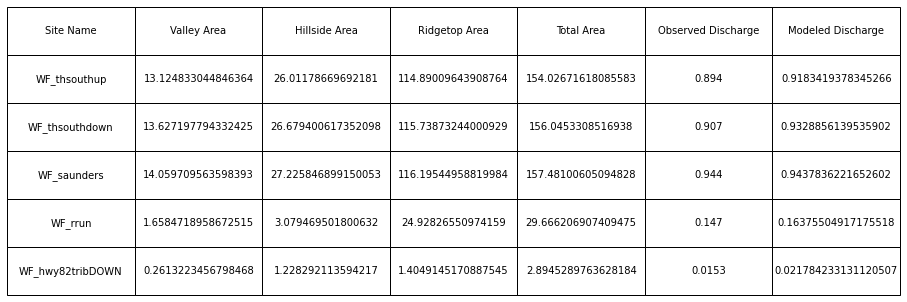

In [10]:
#figure.insert(0, 'Site Name', figure.index)

fig, ax = plt.subplots(figsize=(8, 4))

# Hide axes
ax.set_frame_on(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

table = plt.table(cellText=figure.tail().values, colLabels=figure.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(2,4)  # Adjust the table size
#.savefig(r'D:\Ben_wd\THESIS\figs\table.png', bbox_inches='tight', pad_inches=0.05)
#plt.show()
table

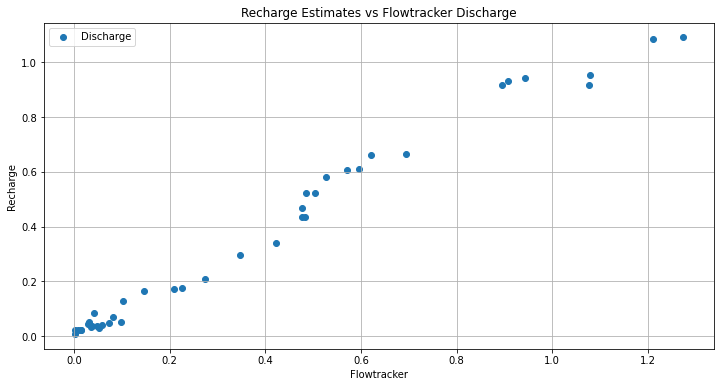

In [49]:
plt.figure(figsize=(12, 6))
plt.scatter(result["Discharge"], result['baseflow_juckem'], label='Discharge')
plt.xlabel('Flowtracker')
plt.ylabel('Recharge')
plt.title(f'Recharge Estimates vs Flowtracker Discharge')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
import plotly.express as px
import pandas as pd

# Create an interactive scatterplot using Plotly Express
fig = px.scatter(result, x='Discharge', y='baseflow_juckem', text='Key', title='Interactive Scatterplot')

# Customize the scatterplot
fig.update_traces(marker=dict(size=12, opacity=0.6),
                  textfont_size=12,
                  textposition='bottom center')

# Show the plot
fig.show()


In [ ]:
Modeled_Observered_discharge_tributaries

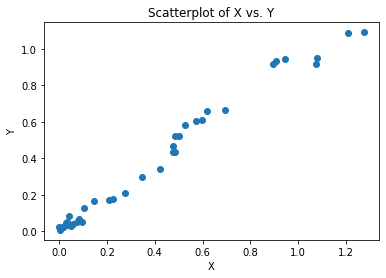

In [51]:
x = np.array(result['Discharge'])
y = np.array(result['baseflow_juckem'])
plt.scatter(x, y)
plt.xlabel('X')

plt.ylabel('Y')
plt.title('Scatterplot of X vs. Y')
plt.show()


In [52]:
correlation_coefficient = np.corrcoef(x, y)[0, 1]
print(f'Correlation Coefficient: {correlation_coefficient}')

Correlation Coefficient: 0.9913211504120594


In [53]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f'Slope: {slope}')
print(f'Intercept: {intercept}')
print(f'R-squared value: {r_value**2}')
print(f'P value: {p_value}')
print(f'Standard Error: {std_err}')

Slope: 0.9265263848731503
Intercept: 0.009643290043214181
R-squared value: 0.9827176232542886
P value: 4.2388902626273216e-35
Standard Error: 0.01993211365706529


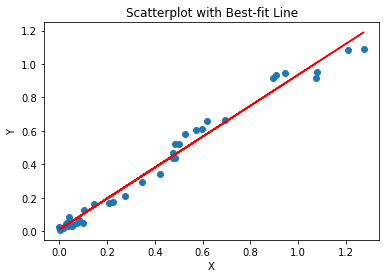

In [54]:
plt.scatter(x, y)
plt.plot(x, slope * x + intercept, color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot with Best-fit Line')
plt.show()

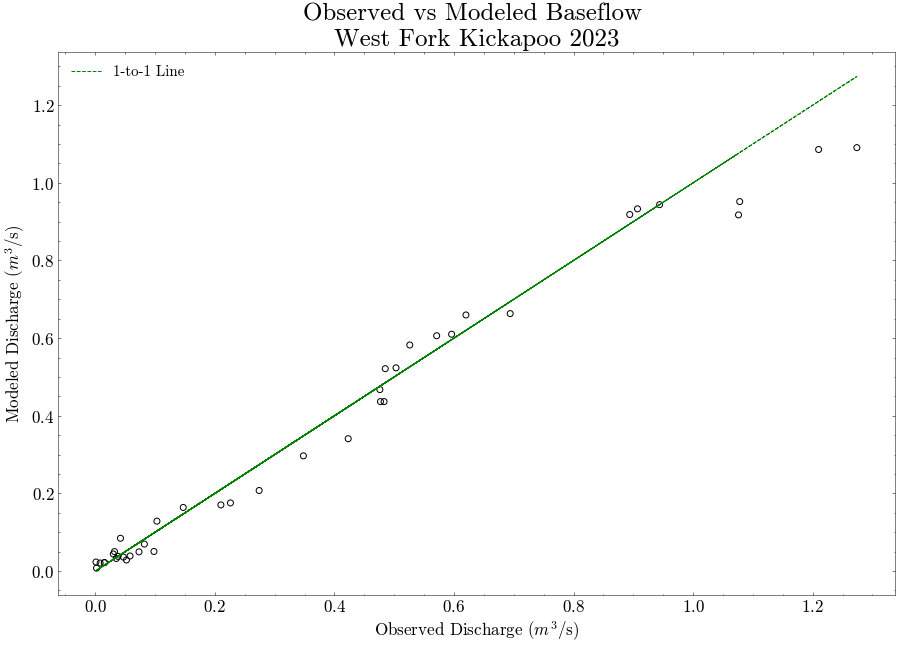

In [55]:
import scienceplots

with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize =(15,10))
    plt.scatter(x, y, facecolors='none', edgecolors='black')
    #plt.plot(x, slope * x + intercept, color='red', label=f'Best-fit Line (R-squared = {r_value**2:.2f})')
    plt.plot(x, x, linestyle='--', color='green', label='1-to-1 Line')
    plt.xlabel('Observed Discharge ($m^{3}$/s)', fontsize = 17)
    plt.ylabel('Modeled Discharge ($m^{3}$/s)', fontsize = 17)
    plt.title('Observed vs Modeled Baseflow \nWest Fork Kickapoo 2023', fontsize = 25)
    plt.legend(fontsize = 15)
    plt.tick_params(axis='both', which='major', labelsize=17)

    plt.savefig('Modeledvsobserved_flowtrackerbaseflow.png')
    plt.show()
    # ^{-1}

In [56]:
tribs = pd.read_csv('Modeled_Observered_discharge_tributaries.csv')
mainstem = pd.read_csv('Modeled_observed_discharge_mainstem.csv')
tribs

FileNotFoundError: [Errno 2] No such file or directory: 'Modeled_Observered_discharge_tributaries.csv'

In [57]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate residuals
residuals = tribs['Modeled Discharge'] - tribs['Observed Discharge']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(tribs['Observed Discharge'], tribs['Modeled Discharge']))

# Plotting
import scienceplots
import matplotlib.pyplot as plt

with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize =(15,10))
    plt.scatter(tribs['Observed Discharge'], tribs['Modeled Discharge'], facecolors='none', edgecolors='black')
    #plt.plot(x, slope * x + intercept, color='red', label=f'Best-fit Line (R-squared = {r_value**2:.2f})')
    plt.plot(tribs['Observed Discharge'], tribs['Observed Discharge'], linestyle='-', color='green', label='1-to-1 Line')
    plt.xlabel('Observed Discharge ($m^{3}$/s)', fontsize = 17)
    plt.ylabel('Modeled Discharge ($m^{3}$/s)', fontsize = 17)
    plt.title('Observed vs Modeled Tributary Baseflow \nWest Fork Kickapoo 2023', fontsize = 25)
    plt.legend(fontsize = 17)
    plt.tick_params(axis='both', which='major', labelsize=17)

    # Add RMSE to the plot
    plt.text(0.02, 0.9, f'RMSE = {rmse:.2f}', transform=plt.gca().transAxes, fontsize=17, verticalalignment='top')

    plt.savefig('Modeledvsobserved_flowtrackerbaseflow_trib.png')
    plt.show()


NameError: name 'tribs' is not defined

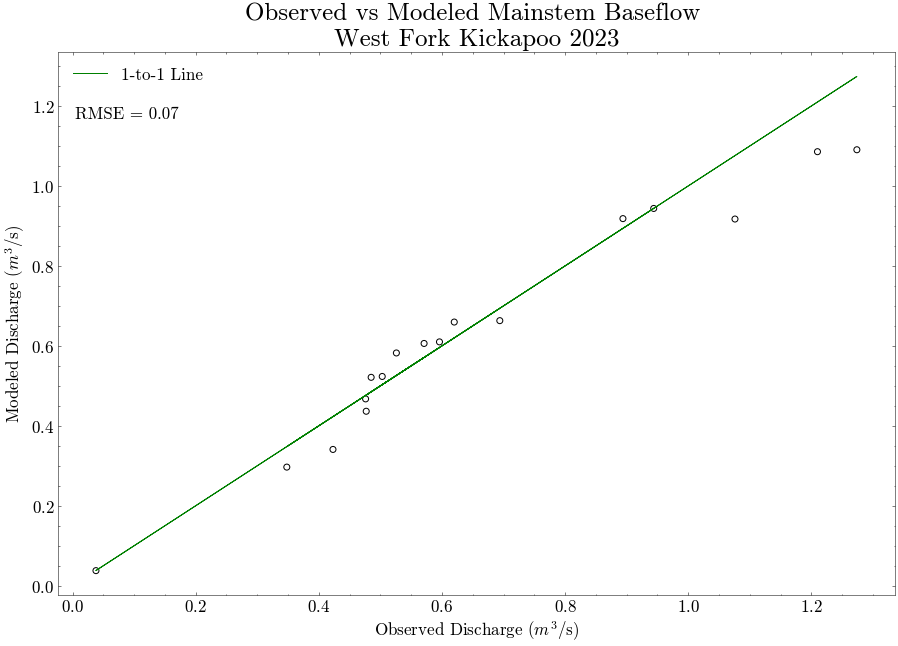

In [57]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate residuals
residuals = mainstem['Modeled Discharge'] - mainstem['Observed Discharge']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(mainstem['Observed Discharge'], mainstem['Modeled Discharge']))

# Plotting
import scienceplots
import matplotlib.pyplot as plt

with plt.style.context(['science', 'no-latex']):
    plt.figure(figsize =(15,10))
    plt.scatter(mainstem['Observed Discharge'], mainstem['Modeled Discharge'], facecolors='none', edgecolors='black')
    #plt.plot(x, slope * x + intercept, color='red', label=f'Best-fit Line (R-squared = {r_value**2:.2f})')
    plt.plot(mainstem['Observed Discharge'], mainstem['Observed Discharge'], linestyle='-', color='green', label='1-to-1 Line')
    plt.xlabel('Observed Discharge ($m^{3}$/s)', fontsize = 17)
    plt.ylabel('Modeled Discharge ($m^{3}$/s)', fontsize = 17)
    plt.title('Observed vs Modeled Mainstem Baseflow \nWest Fork Kickapoo 2023', fontsize = 25)
    plt.legend(fontsize = 17)
    plt.tick_params(axis='both', which='major', labelsize=17)

    # Add RMSE to the plot
    plt.text(0.02, 0.9, f'RMSE = {rmse:.2f}', transform=plt.gca().transAxes, fontsize=17, verticalalignment='top')

    plt.savefig('Modeledvsobserved_flowtrackerbaseflow_mainstem.png')
    plt.show()
